In [1]:
import gym
import numpy as np
import math
import torch
from collections import defaultdict

In [2]:
class QLearning(object):
    def __init__(self, n_state, n_action, cfg):
        self.n_action = n_action
        self.lr = cfg.lr
        self.gamma = cfg.gamma
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table = defaultdict(lambda: np.zeros(n_action))
    
    def sample_action(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp( -1 * self.sample_count / self.epsilon_decay)
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)])
        else:
            action = np.random.choice(self.n_action)
        return action
    
    def predict_action(self, state):
        action = np.argmax(self.Q_table[str(state)])
        return action
    
    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[str(state)][action]
        if terminated:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)])
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

In [3]:
def train(cfg, env, agent):
    print("Training begin!")
    print(f'Enviroment:{cfg.env_name}, Algorithm: {cfg.algo_name}, Device: {cfg.device}')
    rewards = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        state = env.reset(seed=cfg.seed)
        while True:
            action = agent.sample_action(state)
            next_state, reward, terminated, _, info = env.step(action)
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep + 1) % 20 == 0:
            print(f'Epoch: {i_ep}/{cfg.train_eps}, reward: {ep_reward:.1f}, Epsilon: {agent.epsilon:.3f}')
    print('Finish!!!')
    return {"rewards":rewards}

In [4]:
def test(cfg,env,agent):
    print('Testing begin!')
    print(f'Enviroment: {cfg.env_name}, Algorithm: {cfg.algo_name}, Device: {cfg.device}')
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset(seed=cfg.seed)  # 重置环境, 重新开一局（即开始新的一个回合）
        while True:
            action = agent.predict_action(state)  # 根据算法选择一个动作
            next_state, reward, terminated, _, info = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"Epoch: {i_ep+1}/{cfg.test_eps}, Rewards: {ep_reward:.1f}")
    print('Test Finish!')
    return {"rewards":rewards}

In [5]:
import gym
import turtle
import numpy as np

# turtle tutorial : https://docs.python.org/3.3/library/turtle.html

class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

In [6]:
import gym
def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    '''    
    env = gym.make(cfg.env_name)  
    env = CliffWalkingWapper(env)
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = QLearning(n_states,n_actions,cfg)
    return env,agent

In [7]:
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    '''配置参数
    '''
    def __init__(self):
        self.env_name = 'CliffWalking-v0' # 环境名称
        self.algo_name = 'Q-Learning' # 算法名称
        self.train_eps = 400 # 训练回合数
        self.test_eps = 20 # 测试回合数
        self.max_steps = 200 # 每个回合最大步数
        self.epsilon_start = 0.95 #  e-greedy策略中epsilon的初始值
        self.epsilon_end = 0.01 #  e-greedy策略中epsilon的最终值
        self.epsilon_decay = 300 #  e-greedy策略中epsilon的衰减率
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 1 # 随机种子
        if torch.cuda.is_available(): # 是否使用GPUs
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

def smooth(data, weight=0.9):  
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

Training begin!
Enviroment:CliffWalking-v0, Algorithm: Q-Learning, Device: cuda
Epoch: 19/400, reward: -98.0, Epsilon: 0.010
Epoch: 39/400, reward: -46.0, Epsilon: 0.010
Epoch: 59/400, reward: -70.0, Epsilon: 0.010
Epoch: 79/400, reward: -44.0, Epsilon: 0.010
Epoch: 99/400, reward: -22.0, Epsilon: 0.010
Epoch: 119/400, reward: -27.0, Epsilon: 0.010
Epoch: 139/400, reward: -29.0, Epsilon: 0.010
Epoch: 159/400, reward: -33.0, Epsilon: 0.010
Epoch: 179/400, reward: -21.0, Epsilon: 0.010
Epoch: 199/400, reward: -15.0, Epsilon: 0.010
Epoch: 219/400, reward: -31.0, Epsilon: 0.010
Epoch: 239/400, reward: -17.0, Epsilon: 0.010
Epoch: 259/400, reward: -15.0, Epsilon: 0.010
Epoch: 279/400, reward: -15.0, Epsilon: 0.010
Epoch: 299/400, reward: -25.0, Epsilon: 0.010
Epoch: 319/400, reward: -13.0, Epsilon: 0.010
Epoch: 339/400, reward: -13.0, Epsilon: 0.010
Epoch: 359/400, reward: -13.0, Epsilon: 0.010
Epoch: 379/400, reward: -13.0, Epsilon: 0.010
Epoch: 399/400, reward: -13.0, Epsilon: 0.010
Finis

C:\Users\Dream\AppData\Local\Temp\ipykernel_18024\2839720204.py:40: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, len(rewards), 10)  # 设置x轴的范围


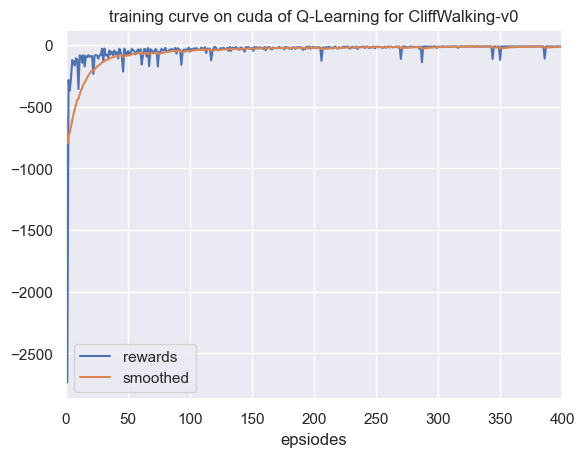

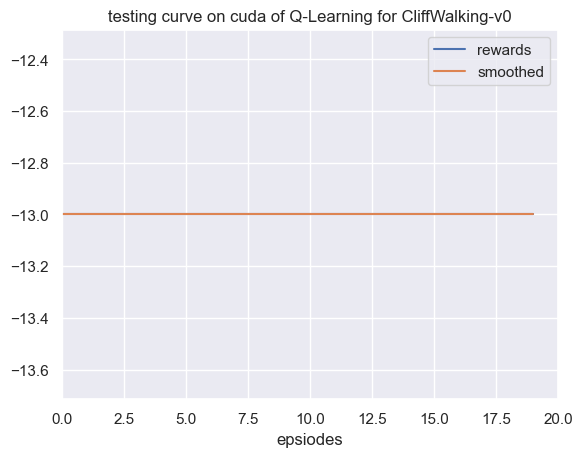

In [8]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果